In [1]:
!pip install -U numpy
!pip install scikit-optimize

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

import sys

%cd '/content/drive/My Drive/Project-RAS'


os.environ['DDE_BACKEND']='pytorch'


import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_dr
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
dde.config.set_random_seed(2023)

Mounted at /content/drive
/content/drive/My Drive/Project-RAS


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
total_training_vx = 900
ls = 0.05

test_data_size = 100
initial_num = 100

check_num = 2000
select_num = 30#stands for how many chosen every time
solver_worker = 0

lr_start = 5e-3
lr_middle = 5e-3
lr_end = 5e-3

iter_start = 0
iter_middle = 0
iter_end = 60000

batch_start = lambda n: 2
batch_middle = lambda n: n // 5
batch_end = lambda n: n

decay_start = None
decay_middle = None
decay_end = None

# if False:
  # makeTesting_dr(size = test_data_size, length_scale = ls)
# makeTesting_dr(size = 1000,length_scale = ls)

In [4]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value

    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [5]:
space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(select_num), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = solver_worker)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(f"datasets/DF_1000_{ls:.2f}_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs, test_grid.shape, test_uxts.shape)


(30, 101) (10201, 2) (30, 10201)
[[ 1.3850499   1.5440884   1.755796   ... -1.445284   -1.7669727
  -1.9704516 ]
 [-0.41721055 -0.32364768 -0.20068924 ...  0.18714754  0.16174012
   0.04998445]
 [ 0.5368845   0.5450927   0.5913005  ...  0.4676569   0.18906356
  -0.06553803]
 ...
 [ 1.641742    1.7161953   1.7562327  ... -0.8426143  -0.76150274
  -0.60615855]
 [ 2.2287402   2.1736064   1.9902866  ...  1.8888345   1.957745
   1.8897184 ]
 [-0.836535   -1.1495248  -1.3660958  ...  0.07686353  0.09866629
   0.17099588]] (10201, 2) (1000, 10201)


In [6]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [7]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam",
              lr= lr_start,
              loss= ["mse"],
              metrics = ["mean l2 relative error"],
              decay = decay_start)


Compiling model...
'compile' took 0.000498 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [1.65e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.65e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 3.371513 s



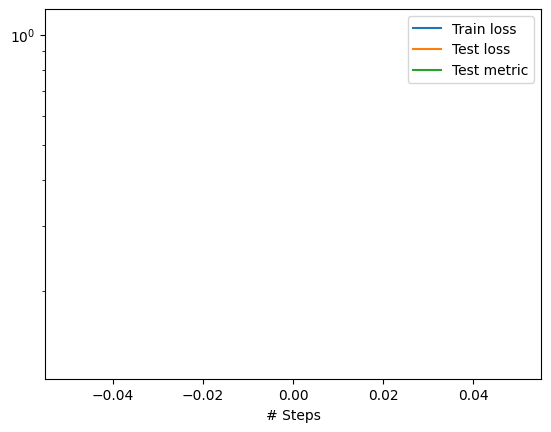

In [8]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

In [9]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}_ct2.csv", index=False)

60
Compiling model...
'compile' took 0.000732 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.26e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.26e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.125543 s



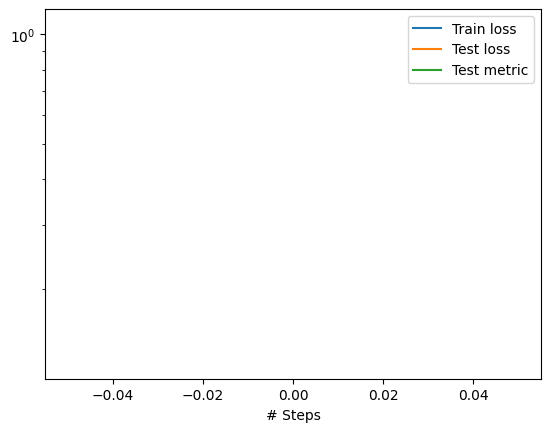

90
Compiling model...
'compile' took 0.000750 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.22e-02]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 9.22e-02
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.117578 s



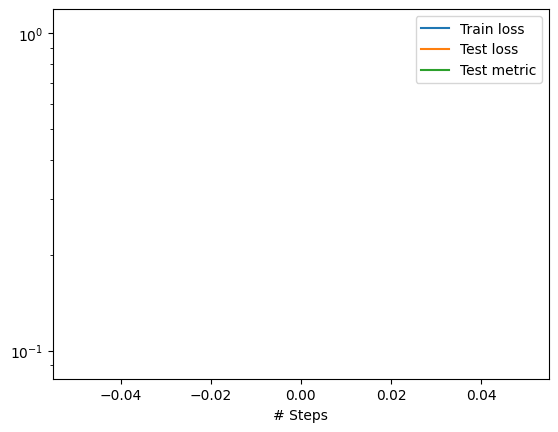

120
Compiling model...
'compile' took 0.000656 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.51e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.51e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.113850 s



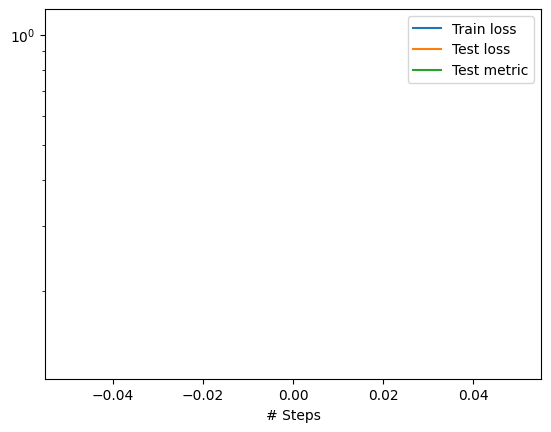

150
Compiling model...
'compile' took 0.001054 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.47e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.47e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.121408 s



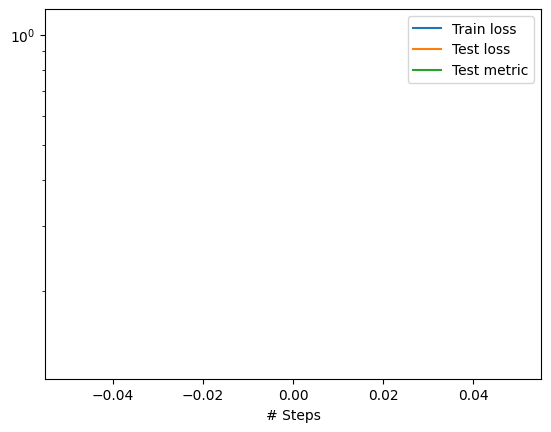

180
Compiling model...
'compile' took 0.000321 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.21e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.21e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.117181 s



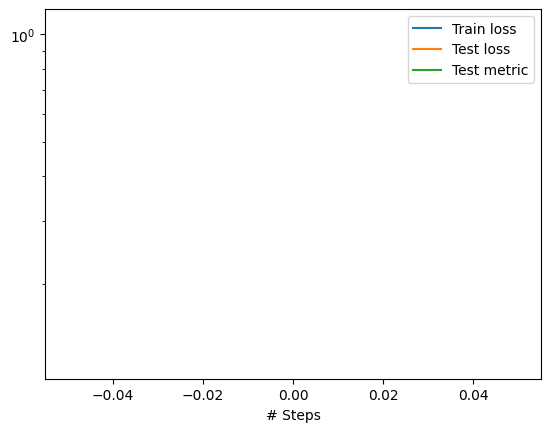

210
Compiling model...
'compile' took 0.000733 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.22e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.22e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.116771 s



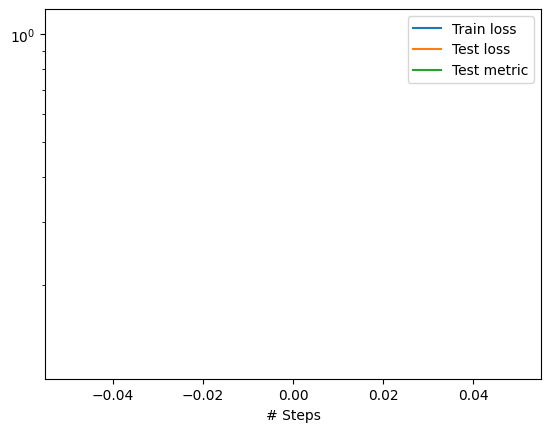

240
Compiling model...
'compile' took 0.000295 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.41e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.41e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.120676 s



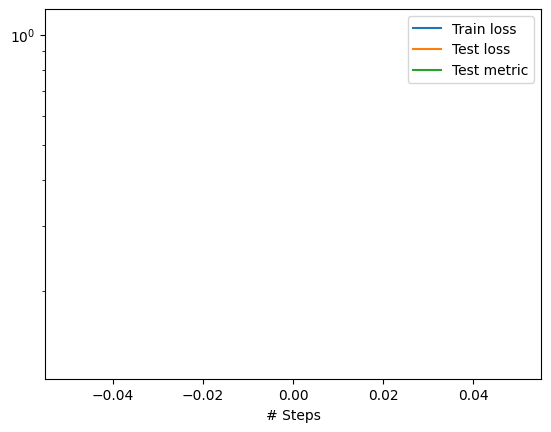

270
Compiling model...
'compile' took 0.000771 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.31e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.31e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.115962 s



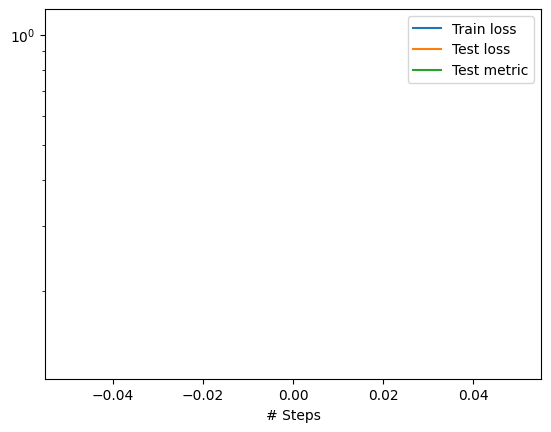

300
Compiling model...
'compile' took 0.000994 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.36e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.36e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.112355 s



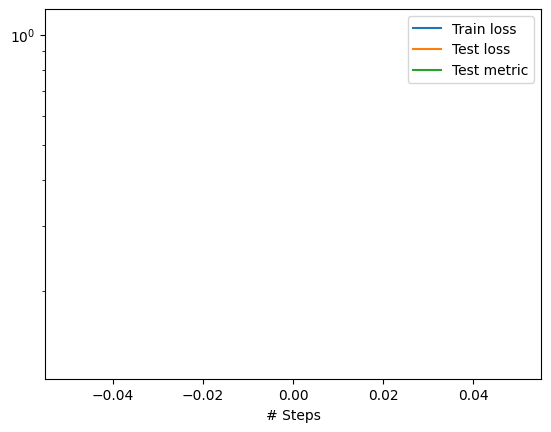

330
Compiling model...
'compile' took 0.000661 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.27e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.27e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.145582 s



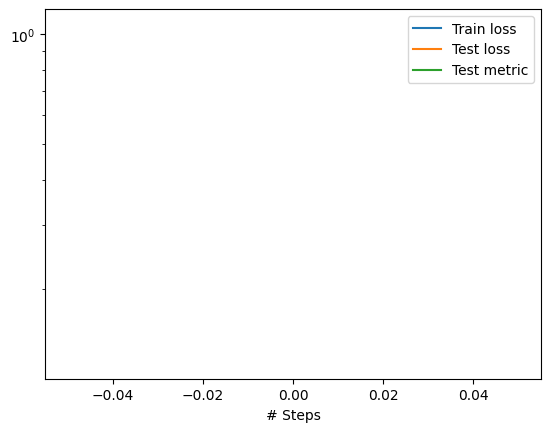

360
Compiling model...
'compile' took 0.000631 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.33e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.33e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.120419 s



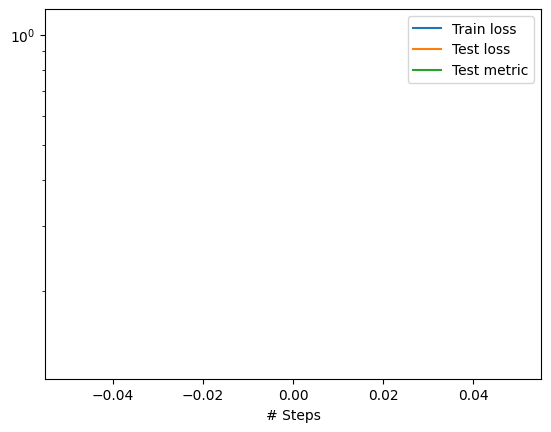

390
Compiling model...
'compile' took 0.000709 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.43e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.43e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.110784 s



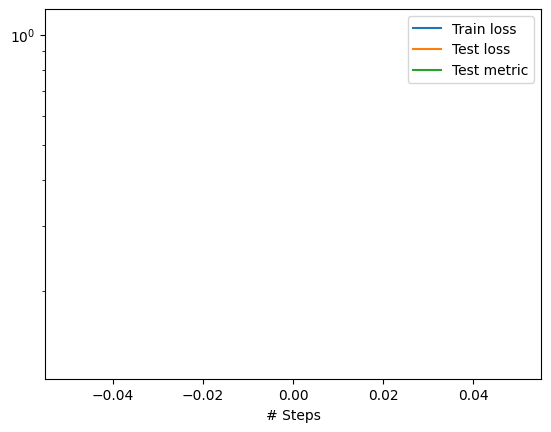

420
Compiling model...
'compile' took 0.000803 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.50e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.50e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.130880 s



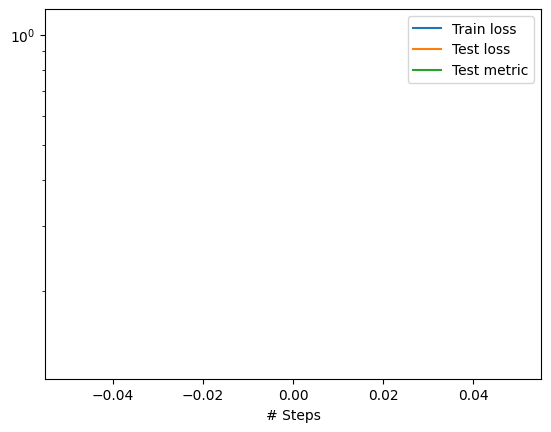

450
Compiling model...
'compile' took 0.000342 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.32e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.32e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.127325 s



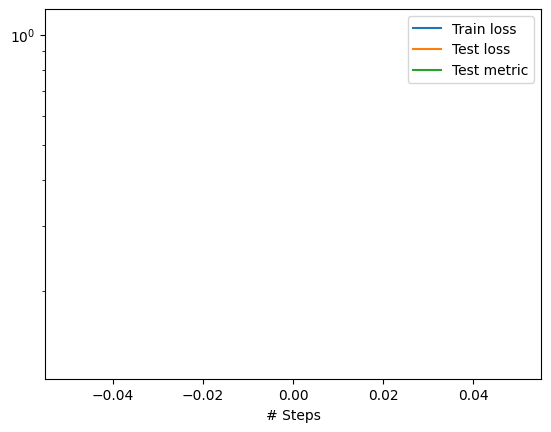

480
Compiling model...
'compile' took 0.000599 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.27e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.27e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.115530 s



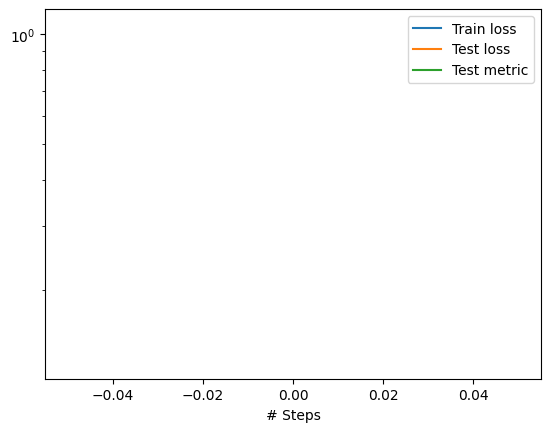

510
Compiling model...
'compile' took 0.000297 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.32e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.32e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.113888 s



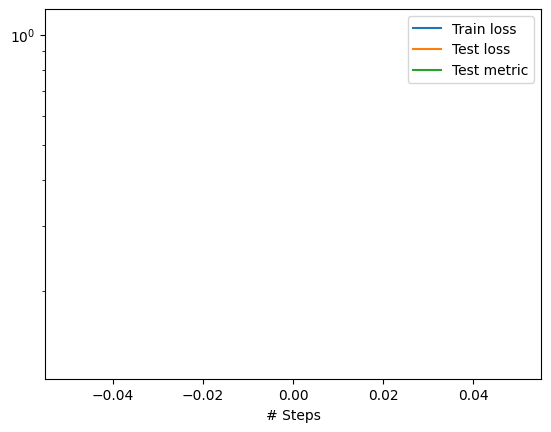

540
Compiling model...
'compile' took 0.001159 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.31e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.31e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.170317 s



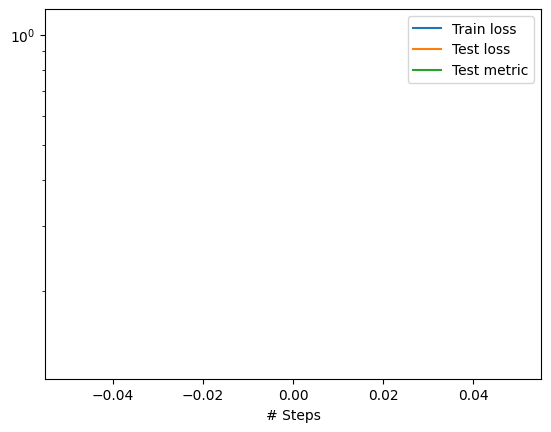

570
Compiling model...
'compile' took 0.000744 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.23e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.23e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.128581 s



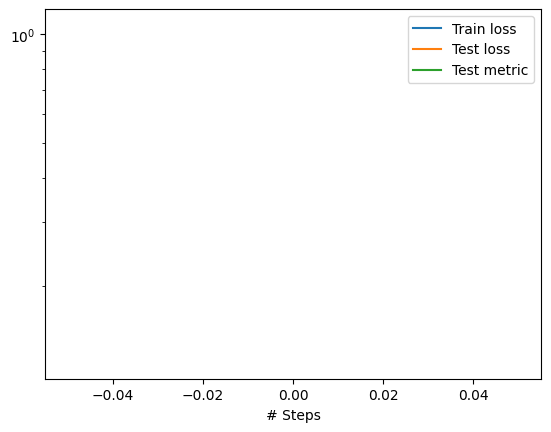

600
Compiling model...
'compile' took 0.000748 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.29e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.29e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.118808 s



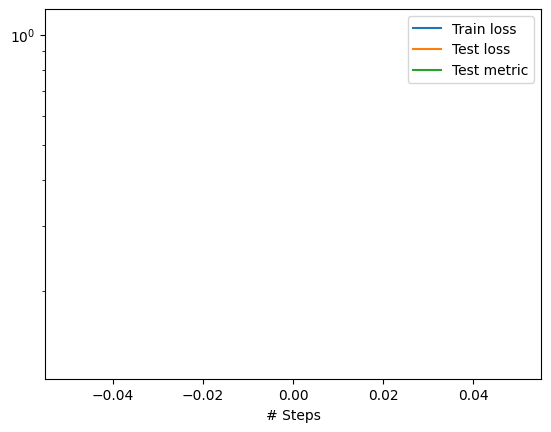

630
Compiling model...
'compile' took 0.000308 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.32e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.32e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.143458 s



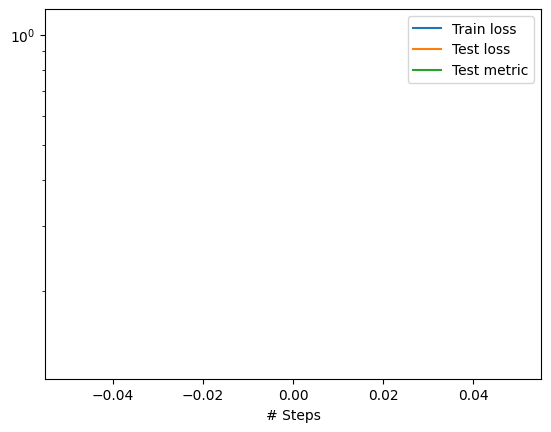

660
Compiling model...
'compile' took 0.000314 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.34e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.34e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.119965 s



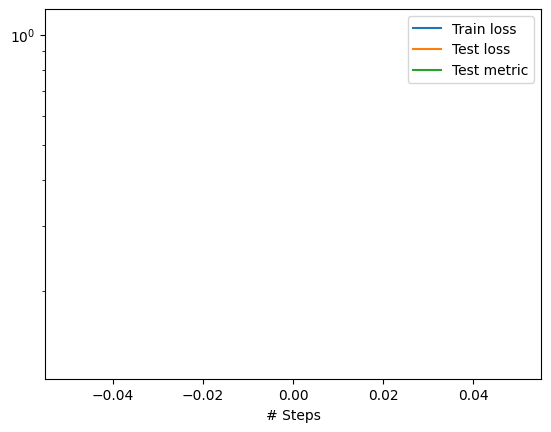

690
Compiling model...
'compile' took 0.000712 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.32e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.32e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.117040 s



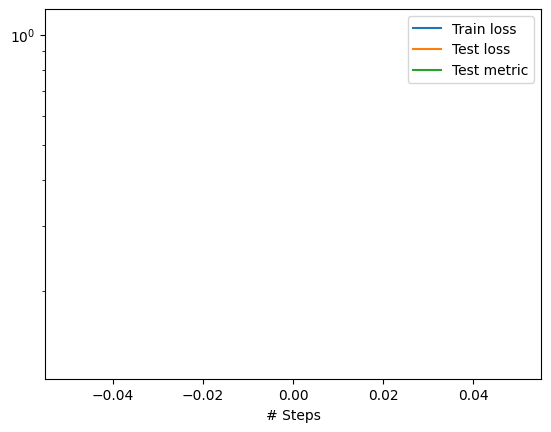

720
Compiling model...
'compile' took 0.000318 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.30e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.30e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.125556 s



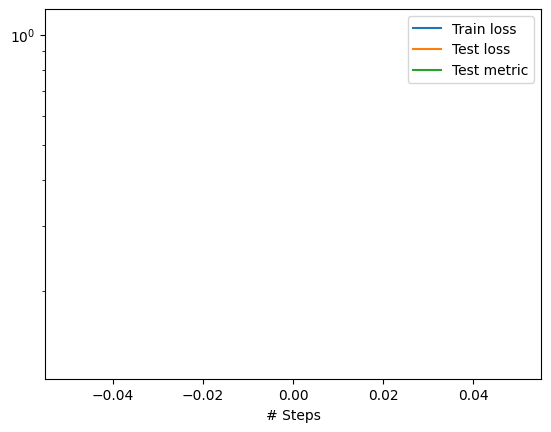

750
Compiling model...
'compile' took 0.000655 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.40e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.40e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.295228 s



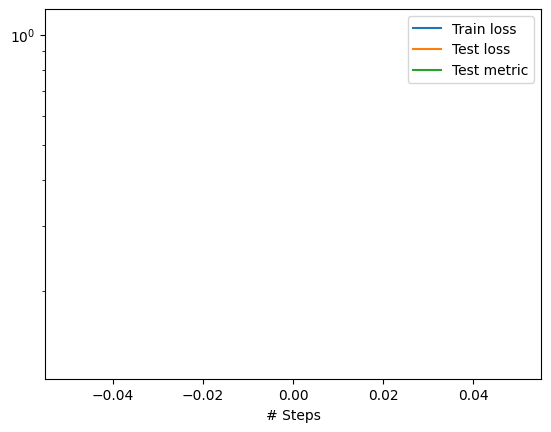

780
Compiling model...
'compile' took 0.000736 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.39e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.39e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.143884 s



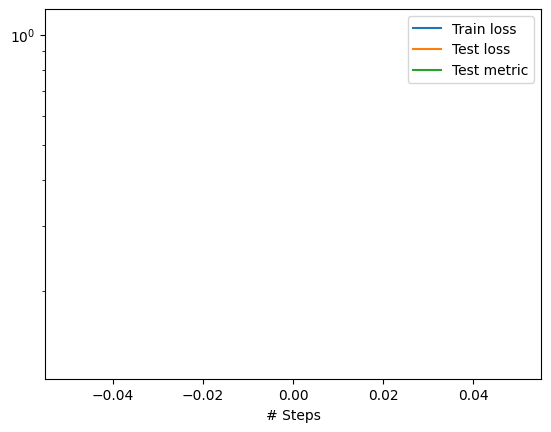

810
Compiling model...
'compile' took 0.000299 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.45e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.45e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.129716 s



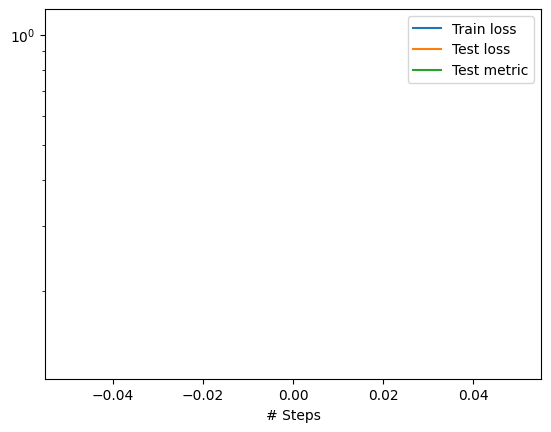

840
Compiling model...
'compile' took 0.000335 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.37e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.37e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.127915 s



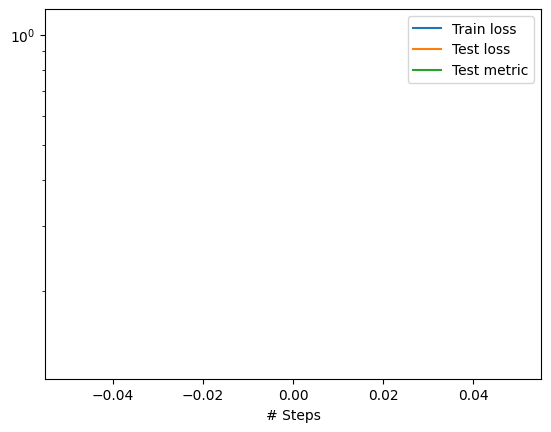

870
Compiling model...
'compile' took 0.000679 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.27e-01]    [1.28e-01]    [1.06e+00]    

Best model at step 0:
  train loss: 1.27e-01
  test loss: 1.28e-01
  test metric: [1.06e+00]

'train' took 0.121689 s



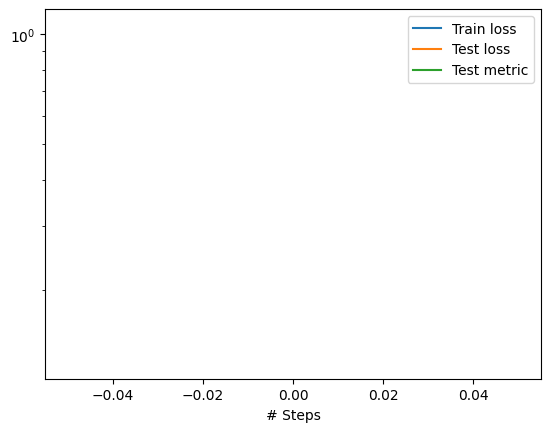

900
Compiling model...
'compile' took 0.000328 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.28e-01]    [1.28e-01]    [1.06e+00]    
1000      [2.66e-03]    [2.69e-03]    [1.69e-01]    
2000      [8.53e-04]    [8.74e-04]    [9.66e-02]    
3000      [3.54e-04]    [3.56e-04]    [6.26e-02]    
4000      [3.39e-04]    [3.33e-04]    [6.04e-02]    
5000      [2.06e-04]    [2.01e-04]    [4.71e-02]    
6000      [1.33e-04]    [1.32e-04]    [3.83e-02]    
7000      [1.17e-04]    [1.17e-04]    [3.61e-02]    
8000      [7.25e-05]    [7.30e-05]    [2.85e-02]    
9000      [2.50e-04]    [2.50e-04]    [5.10e-02]    
10000     [7.42e-05]    [7.51e-05]    [2.88e-02]    
11000     [4.61e-05]    [4.67e-05]    [2.28e-02]    
12000     [1.42e-03]    [1.54e-03]    [1.30e-01]    
13000     [2.29e-04]    [2.44e-04]    [5.22e-02]    
14000     [1.23e-04]    [1.28e-04]    [3.77e-02]    
15000     [8.39e-05]    [8.70e-05]    [3.11e-02]    
16000     [7.30e-05]    [7.46e

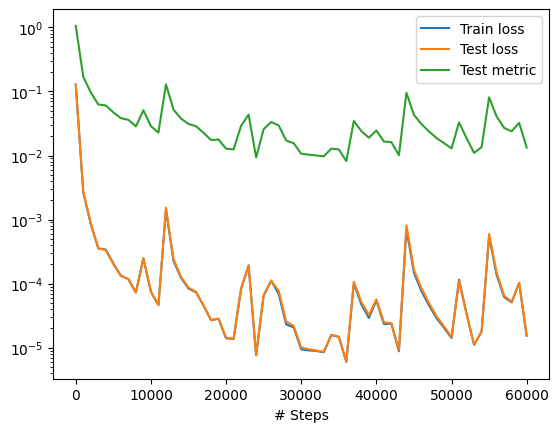

In [10]:

while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, select_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()

    uxts = parallel_solver(diffusion_reaction_solver, a[0], num_workers = solver_worker)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, a[0]], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)

    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam",
                  lr = lr,
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}_ct2.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/loss_history_{date}_ct2.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()

torch.save(model.state_dict(), f"results/model_{date}_ct2.pth")